## 2.3　モデルの検証

### 2.3.1　汎化性能

In [1]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import nn, optim
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

In [2]:
plt.rcParams['figure.figsize'] = (5, 5)

In [3]:
def seed_torch(seed=1485):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

In [4]:
def train_1epoch(model, train_loader, lossfun, optimizer, device):
  model.train()
  total_loss, total_acc = 0.0, 0.0

  for x, y in tqdm(train_loader):
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    out = model(x)

    loss = lossfun(out, y)
    loss.backward()

    optimizer.step()

    total_loss += loss.item() * x.size(0)

    _, pred = torch.max(out, 1)
    total_acc += torch.sum(pred == y.data)

  avg_loss = total_loss / len(train_loader.dataset)
  avg_acc = total_acc / len(train_loader.dataset)

  return avg_acc, avg_loss

In [5]:
def validate_1epoch(model, val_loader, lossfun, device):
  model.eval()
  total_loss, total_acc = 0.0, 0.0

  with torch.no_grad():
    for x, y in tqdm(val_loader):
      x = x.to(device)
      y = y.to(device)

      out = model(x)
      loss = lossfun(out, y)
      _, pred = torch.max(out, 1)

      total_loss += loss.item() * x.size(0)
      total_acc += torch.sum(pred == y.data)

  avg_loss = total_loss / len(val_loader.dataset)
  avg_acc = total_acc / len(val_loader.dataset)

  return avg_acc, avg_loss

In [6]:
def predict(model, loader, device):
  pred_fun = torch.nn.Softmax(dim=1)
  preds = []

  for x, _ in tqdm(loader):
    with torch.set_grad_enabled(False):
      x = x.to(device)
      y = pred_fun(model(x))

    y = y.cpu().numpy()
    y = np.argmax(y, axis=1)
    preds.append(y)

  preds = np.concatenate(preds)

  return preds

In [7]:
seed_torch()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
digits = load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=0)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_valid = torch.tensor(y_valid, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_dataset = TensorDataset(X_valid, y_valid)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
model = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

model = model.to(device)

lossfun = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

100%|██████████| 9/9 [00:00<00:00, 286.46it/s]


train acc 0.9990049600601196
valid acc 0.9642857313156128
test_acc 0.9592592592592593


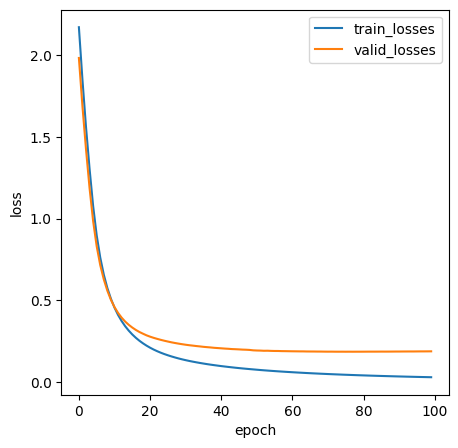

In [10]:
train_losses = []
valid_losses = []

for ep in range(100):
  train_acc, train_loss = train_1epoch(model, train_loader, lossfun, optimizer, device)
  valid_acc, valid_loss = validate_1epoch(model, val_loader, lossfun, device)

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

plt.plot(train_losses, label='train_losses')
plt.plot(valid_losses, label='valid_losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

test_preds = predict(model, test_loader, device)

print('train acc', train_acc.item())
print('valid acc', valid_acc.item())
print('test_acc', sum(y_test.detach().numpy().copy() == test_preds) / len(y_test))

### 2.3.3　交差検証

In [11]:
def predict(model, loader, device):
  pred_fun = torch.nn.Softmax(dim=1)
  preds = []

  for x, _ in tqdm(loader):
    with torch.set_grad_enabled(False):
      x = x.to(device)
      y = pred_fun(model(x))

    y = y.cpu().numpy()
    # y = np.argmax(y, axis=1)
    preds.append(y)

  preds = np.concatenate(preds)

  return preds

In [12]:
seed_torch()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
digits = load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
model = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

model = model.to(device)

lossfun = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [15]:
cv = KFold(n_splits=5)
oof_train = np.zeros((len(X_train), 10))

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
test_preds = []

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
  X_tr, X_val = X_train[train_index], X_train[valid_index]
  y_tr, y_val = y_train[train_index], y_train[valid_index]

  X_tr = torch.tensor(X_tr, dtype=torch.float32)
  X_val = torch.tensor(X_val, dtype=torch.float32)
  y_tr = torch.tensor(y_tr, dtype=torch.int64)
  y_val = torch.tensor(y_val, dtype=torch.int64)

  train_dataset = TensorDataset(X_tr, y_tr)
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
  val_dataset = TensorDataset(X_val, y_val)
  val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

  for ep in range(100):
    train_acc, train_loss = train_1epoch(model, train_loader, lossfun, optimizer, device)
    valid_acc, valid_loss = validate_1epoch(model, val_loader, lossfun, device)

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  train_accs.append(train_acc.item())
  valid_accs.append(valid_acc.item())
  oof_train[valid_index] = predict(model, val_loader, device)
  test_preds.append(predict(model, test_loader, device))

print('\ntrain acc', np.mean(train_accs))
print('valid acc（各 fold の平均）', np.mean(valid_accs))
print('valid acc（再計算）', sum(y_train == np.argmax(oof_train, axis=1)) / len(y_train))

test_preds = np.mean(test_preds, axis=0)
test_preds = np.argmax(test_preds, axis=1)

print('test acc', sum(y_test.detach().numpy().copy() == test_preds) / len(y_test))

100%|██████████| 9/9 [00:00<00:00, 552.22it/s]



train acc 0.9996019959449768
valid acc（各 fold の平均） 0.9849143147468566
valid acc（再計算） 0.984884645982498
test acc 0.9648148148148148


### 2.3.4　多様な検証方法の使い分け

In [16]:
def calc_label_dist(y):
  unique, counts = np.unique(y, return_counts=True)
  return np.asarray((unique, counts / len(y))).T

In [17]:
seed_torch()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
digits = load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [19]:
model = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

model = model.to(device)

lossfun = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [20]:
print('==========y_train==========')
print(calc_label_dist(y_train))

kf = KFold(n_splits=5)
print('==========KFold==========')
for fold_id, (train_index, valid_index) in enumerate(kf.split(X_train)):
  if fold_id == 0:
    y_tr, y_val = y_train[train_index], y_train[valid_index]
    print(calc_label_dist(y_tr))

print('==========StratifiedKFold==========')
skf = StratifiedKFold(n_splits=5)
for fold_id, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
  if fold_id == 0:
    y_tr, y_val = y_train[train_index], y_train[valid_index]
    print(calc_label_dist(y_tr))

==========y_train==========
[[0.         0.09864757]
 [1.         0.10103421]
 [2.         0.09864757]
 [3.         0.10182975]
 [4.         0.10103421]
 [5.         0.10103421]
 [6.         0.10103421]
 [7.         0.09944312]
 [8.         0.09705648]
 [9.         0.10023866]]
==========KFold==========
[[0.         0.09253731]
 [1.         0.09452736]
 [2.         0.08656716]
 [3.         0.10248756]
 [4.         0.10646766]
 [5.         0.10746269]
 [6.         0.10049751]
 [7.         0.10746269]
 [8.         0.09751244]
 [9.         0.10447761]]
==========StratifiedKFold==========
[[0.         0.09850746]
 [1.         0.10049751]
 [2.         0.09850746]
 [3.         0.10248756]
 [4.         0.10149254]
 [5.         0.10049751]
 [6.         0.10149254]
 [7.         0.09950249]
 [8.         0.09651741]
 [9.         0.10049751]]


In [21]:
cv = StratifiedKFold(n_splits=5)
oof_train = np.zeros((len(X_train), 10))

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
test_preds = []

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
  X_tr, X_val = X_train[train_index], X_train[valid_index]
  y_tr, y_val = y_train[train_index], y_train[valid_index]

  X_tr = torch.tensor(X_tr, dtype=torch.float32)
  X_val = torch.tensor(X_val, dtype=torch.float32)
  y_tr = torch.tensor(y_tr, dtype=torch.int64)
  y_val = torch.tensor(y_val, dtype=torch.int64)

  train_dataset = TensorDataset(X_tr, y_tr)
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
  val_dataset = TensorDataset(X_val, y_val)
  val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

  for ep in range(100):
    train_acc, train_loss = train_1epoch(model, train_loader, lossfun, optimizer, device)
    valid_acc, valid_loss = validate_1epoch(model, val_loader, lossfun, device)

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  train_accs.append(train_acc.item())
  valid_accs.append(valid_acc.item())
  oof_train[valid_index] = predict(model, val_loader, device)
  test_preds.append(predict(model, test_loader, device))

print('\ntrain acc', np.mean(train_accs))
print('valid acc（各 Fold の平均）', np.mean(valid_accs))
print('valid acc（再計算）', sum(y_train == np.argmax(oof_train, axis=1)) / len(y_train))

test_preds = np.mean(test_preds, axis=0)
test_preds = np.argmax(test_preds, axis=1)

print('test acc', sum(y_test.detach().numpy().copy() == test_preds) / len(y_test))

100%|██████████| 9/9 [00:00<00:00, 678.21it/s]


train acc 0.9996019959449768
valid acc（各 Fold の平均） 0.9849143147468566
valid acc（再計算） 0.984884645982498
test acc 0.9685185185185186
